# pythia-features

In [81]:
import os
from typing import Dict, List, Tuple

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from utils import utils, stats

In [82]:
# Knobs
#data_path = '/u/cmolder/GitHub/Pythia/out/pythia_level/exp_394r/exp_394r_features.csv' # Max pooling
data_path = '/u/cmolder/GitHub/Pythia/out/pythia_level/exp_394r/exp_394r_features_degree1.csv' # Max pooling, degree 1
#data_path = '/u/cmolder/GitHub/Pythia/out/pythia_level/exp_394r/exp_394r_features_sum.csv' # Sum pooling

seed = 1337
output_dir = './plots/pythia_features'
suites = {
    'SPEC 06': utils.spec06,
    #'SPEC 17': utils.spec17,
    #'GAP': utils.gap,
}
metrics  = [
    'ipc_improvement', 
    'L2C_issued_prefetches', 
    'L2C_mpki_reduction', 
    'L2C_accuracy', 
    'L2C_coverage'
]

features = [
    # --- Current graphs ---
    set(['Delta_Path', 'PC_Delta']),
    set(['PC']),
    set(['PC_Delta']),
    set(['Delta_Path']),
    set(['Address']),
    set(['Delta']),
    set(['Offset']),
    set(['Page'])
    # --- Old graphs ---
    # set(['Delta_Path']),
    # set(['Delta_Path', 'PC_Delta']),
    # set(['PC']),
    # set(['PC', 'Delta_Path', 'PC_Delta']),
    # set(['PC', 'PC_Address', 'Delta_Path', 'PC_Delta']),
    # set(['PC', 'PC_Address', 'PC_Delta']),
    # set(['PC', 'PC_Delta']),
    # set(['PC_Delta'])
]

dpi = 120
figsize = (10, 6)

In [83]:
def load_data(data_path: str, 
              feature_sets: List[str] = []) \
              -> Dict[str, pd.DataFrame]:
    """Load different feature groupings, as stored in a 
    .csv file generated from the evaluate script in 
    Pythia/experiments.
    """
    setify = lambda r : set(eval(r)) # Convert string/tuple to unordered set.
    set_string = lambda s : ', '.join(f for f in s) # Convert set to string.
    data_df = {}
    df = utils.read_data_file(data_path)
    df = df[df.seed == seed]
    if feature_sets == []:
        feature_sets = df.pythia_features.unique()
        feature_sets = [setify(s) for s in feature_sets]
    for feat_set in feature_sets:
        data_df[set_string(feat_set)] = (
            df[df.pythia_features.apply(setify) == feat_set])

    return data_df
    
data_df : dict = load_data(data_path, feature_sets=features)

---
## Metrics of each static threshold
- How does each static threshold compare to regular Pythia, and no prefetcher?

In [84]:
def plot_metric(dfs: dict, 
                metric: str, 
                dpi: int = None, 
                figsize: Tuple[int, int] = None,
                suite_name: str = '') -> None:
    """Plot the metric between the dfs on each trace
    in a suite.
    """
    match_prefetcher = lambda x : x != ('no', 'no', 'no') # Used in p_samples
    
    fig, ax = plt.subplots(dpi=dpi, figsize=figsize)
    num_samples = len(dfs.items())
    gap = num_samples + 1

    traces = list(list(dfs.values())[0].trace.unique())
    trace_names = traces + (['amean'] if metric in utils.amean_metrics else ['gmean'])
    traces = traces + ['mean']

    largest_y = 0
    for i, (setup, df) in enumerate(dfs.items()):
        df = df[df.pythia_level_threshold == float('-inf')]
        df = stats.add_means(df) # Add mean as an extra trace
        for j, tr in enumerate(traces):
            rows = df[df.trace == tr]
            pos = (gap * j) + i
            #print(f'[DEBUG] i={i} j={j} setup={setup} tr={tr} pos={pos}, {pos+1}')
            p_samples = (rows[rows.all_pref.apply(match_prefetcher)][metric])
            #p_min = p_samples.min()
            p_mean = p_samples.mean(), 
            p_max = p_samples.max()
            largest_y = max(largest_y, p_max)
            
            #print(f'[DEBUG] {tr} Regular {setup} {p_mean:.2f} {p_min:.2f} {p_max:.2f}')
            ax.bar(pos, p_mean, 
                   label=f'{setup}' if j == 0 else None, 
                   color=f'C{i}')
            # ax.errorbar(pos, p_mean, 
            #             yerr=[[p_mean - p_min], [p_max - p_mean]], 
            #             color='black')

    ax.set_xticks(np.arange(0, len(df.trace.unique())) * gap + (num_samples/2))
    ax.set_xticklabels(trace_names, rotation=90)
    ax.set_xlabel('Trace')

    # Set ticks based on metric
    if any(s in metric for s in ['ipc_improvement', 'accuracy', 'coverage', 'mpki_reduction']):
        #largest_y = 150
        ax.set_yticks(np.arange(0, round(largest_y, -1) + 10, 10))

    ax.set_ylabel(metric.replace('_', ' '))
    ax.grid(axis='y', color='lightgray')
    ax.set_axisbelow(True)
        
    fig.legend() #bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
    fig.suptitle(f'{metric.replace("_", " ")} ({suite_name})')
    fig.tight_layout()

---
# Feature selection

SPEC 06


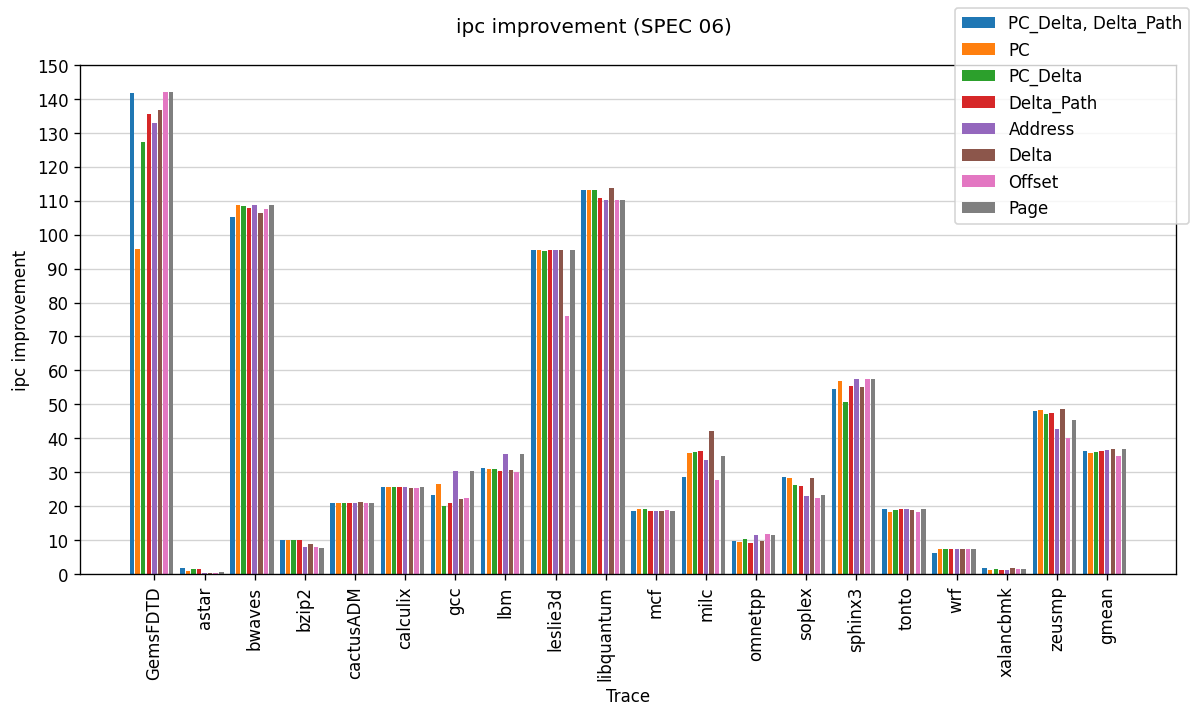

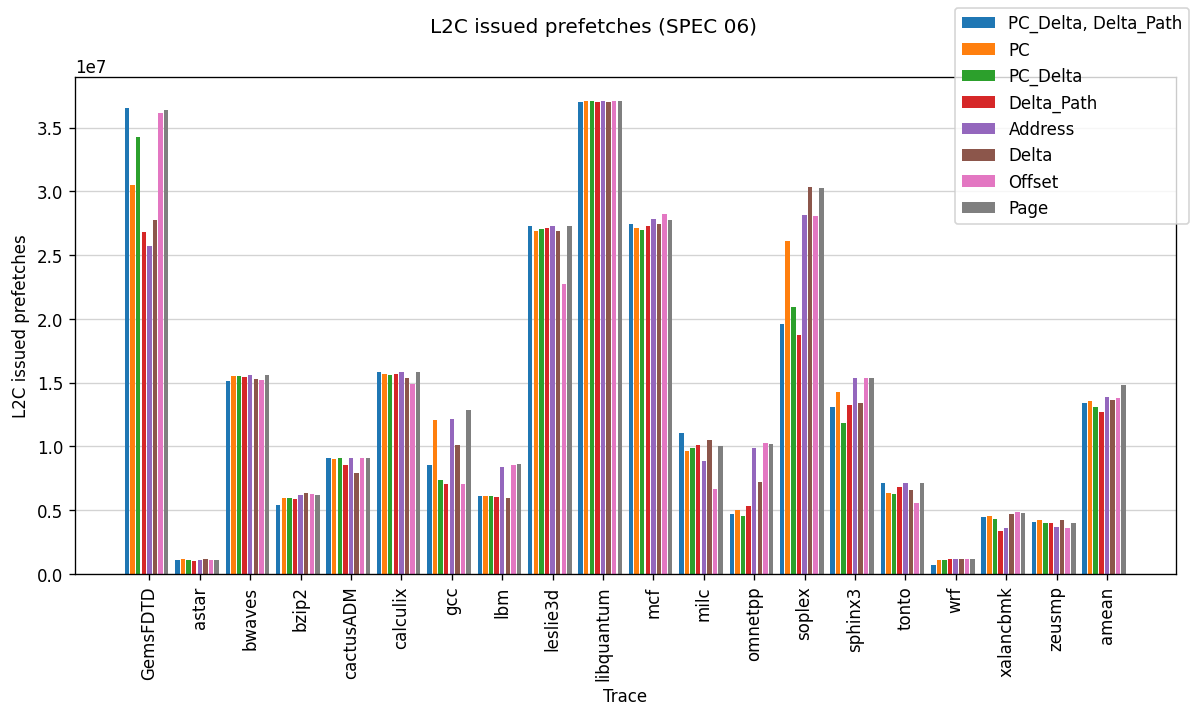

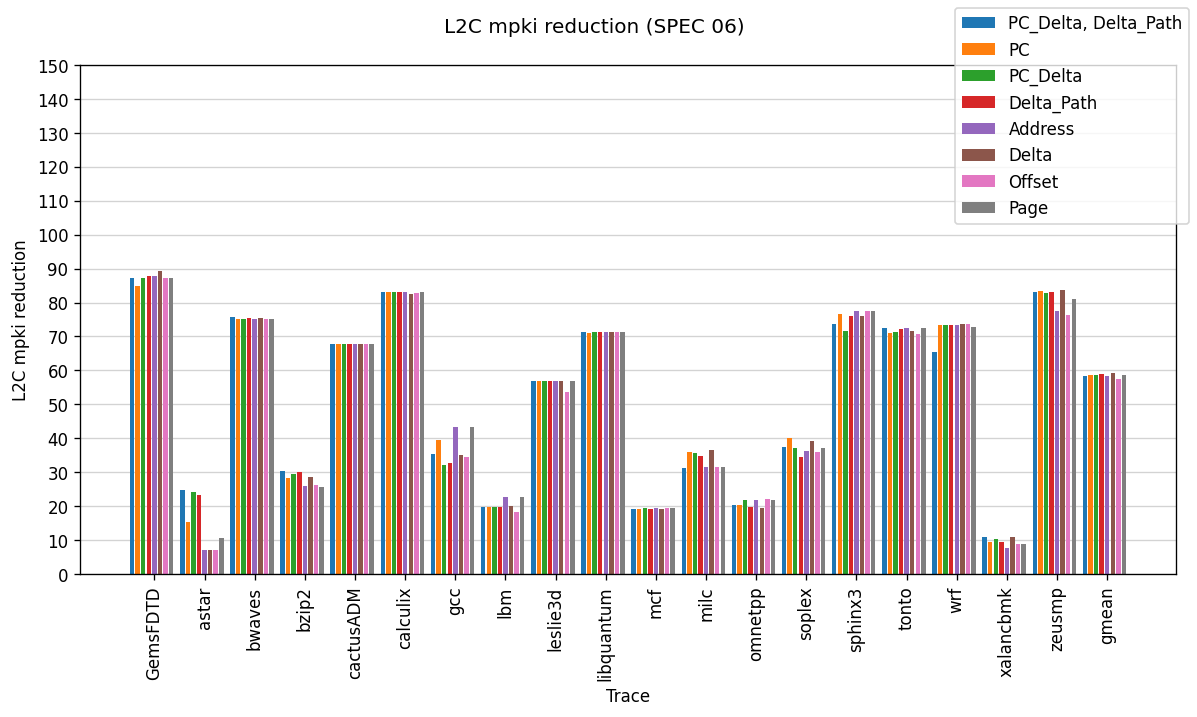

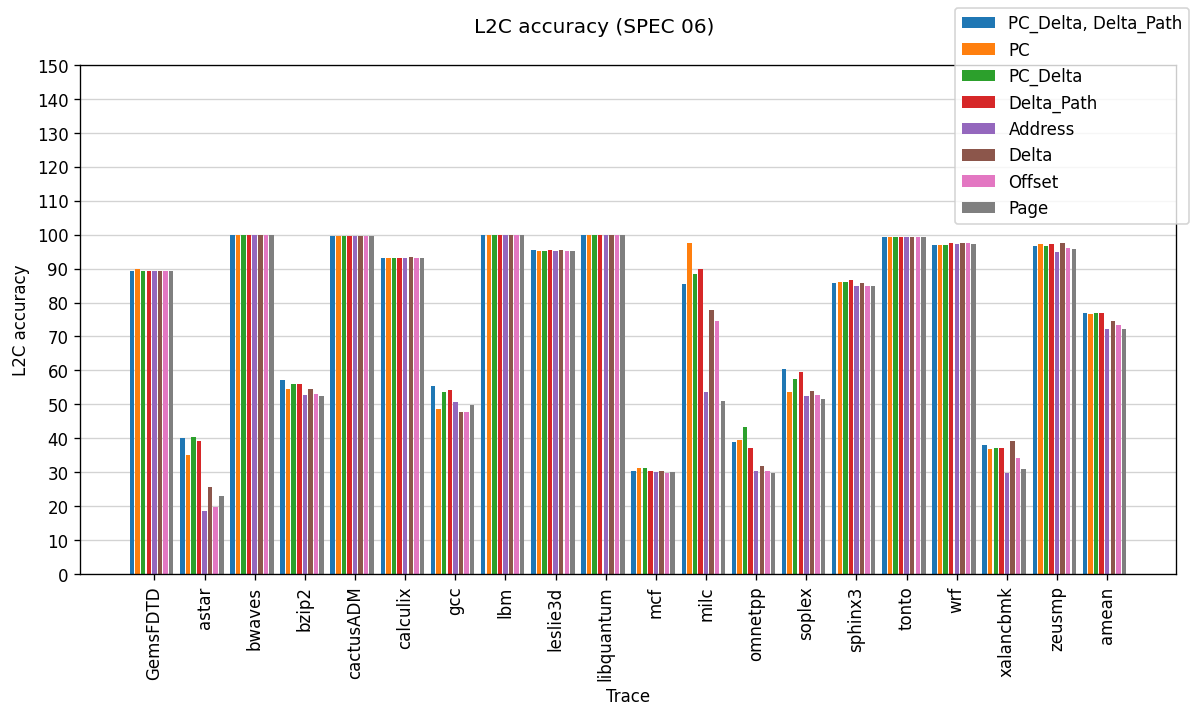

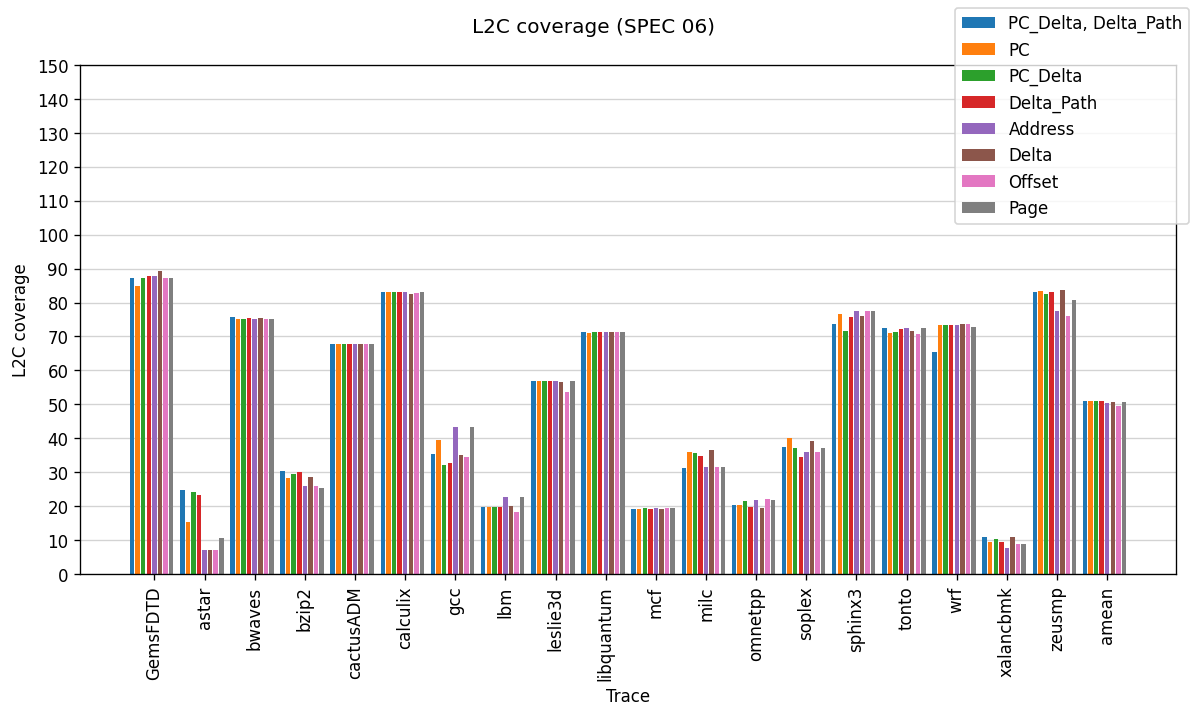

In [85]:
#os.makedirs(f'{output_dir}/', exist_ok=True)
for suite_name, suite in suites.items():
    data_df_ = {k : v[v.trace.isin(suite)] for k,v in data_df.items()}
    print(suite_name)
    for metric in metrics: 
        plot_metric(data_df_, metric, 
                    suite_name=suite_name, figsize=figsize, dpi=dpi)
        plt.show()
        # plt.savefig(f'{output_dir}/{suite_name}_{metric}.pdf', 
        #             bbox_inches='tight')

# Baselines

In [ ]:
max_pool_path: str = '/u/cmolder/GitHub/Pythia/out/pythia_level/exp_394r/exp_394r_features.csv' # Max pooling
sum_pool_path: str = '/u/cmolder/GitHub/Pythia/out/pythia_level/exp_394r/exp_394r_features_sum.csv' # Sum pooling
baseline_path: str = '/u/cmolder/GitHub/Pythia/out/pythia_level/exp_394r/exp_394r_features_baseline.csv' # Baselines

In [ ]:
def load_data_baseline(max_pool_path, sum_pool_path, baseline_path, 
                       features=('Delta_Path', 'PC_Delta'),
                       baselines=('bingo', 'spp', 'bingo_spp', 'stride')) \
    -> Dict[Tuple[str, ...], pd.DataFrame]:
    """Load different feature groupings for the baseline analysis.
    """
    data_df = {}
    max_df = utils.read_data_file(max_pool_path)
    max_df = max_df[(max_df.seed == seed) & 
                    (max_df.simpoint == 'weighted') &
                    (max_df.pythia_features == str(features))]
    data_df['max'] = max_df

    sum_df = utils.read_data_file(sum_pool_path)
    sum_df = sum_df[(sum_df.seed == seed) & 
                    (sum_df.simpoint == 'weighted') &
                    (sum_df.pythia_features == str(features))]
    data_df['sum'] = sum_df

    base_df = utils.read_data_file(baseline_path)
    base_df = base_df[(base_df.seed == seed) &
                      (base_df.simpoint == 'weighted')]
    # TODO: See why there are NaN baseline metrics. 
    # (fillna is a temporary fix and should be removed, it skews values)
    base_df.fillna(0, inplace=True)
    for pf in baselines:
        data_df[pf] = base_df[base_df.all_pref == ('no', pf, 'no')]

    return data_df
    
data_df : dict = load_data_baseline(max_pool_path, sum_pool_path, baseline_path)
data_df.keys()

dict_keys(['max', 'sum', 'bingo', 'spp', 'bingo_spp', 'stride'])

In [8]:
for suite_name, suite in zip(suite_names, suites):
    data_df_ = {k : v[v.trace.isin(suite)] for k,v in data_df.items()}
    
    print(suite_name)
    for metric in metrics: 
        plot_metric(
            data_df_, metric,
            suite_name=suite_name,
            figsize=(10,6),
            dpi=dpi
        )
        plt.savefig(
            f'{output_dir}/{suite_name}_{metric}_baselines.pdf', 
            bbox_inches='tight'
        )

NameError: name 'suite_names' is not defined